## Introduction

**The purpose of the task**  is to classify breast cancer using machine learning algorithms and a neural network and compare them.To achieve the purpose, it is necessary to solve the following tasks:
* Data preparation and analysis; 
* Implementation of machine learning algorithms;
* Neural network implementation; 
* Сonclusions.

Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension ("coastline approximation" - 1)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,f1_score,auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

## Data preparation and analysis

In [3]:
df = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')


In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [5]:
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [6]:
df.drop(columns = ['id','Unnamed: 32'],inplace = True)

In [7]:
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [8]:
df['diagnosis'] = df['diagnosis'].map({"M":1,"B":0})

We do not have balanced classes and the accuracy metric does not suit us, we will use the f1-score and ROC-AUC for further analysis.

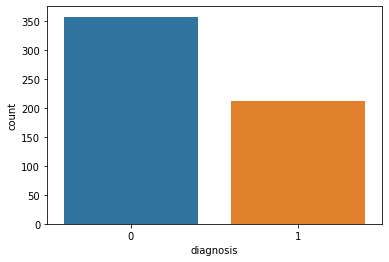

In [9]:
sns.countplot(x = 'diagnosis',data=df)
plt.show()

Where the correlation is less than 0.7, we won't use these features.

In [10]:
df.corr().style.background_gradient()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,-0.012838,0.567134,-0.008303,0.556141,0.548236,-0.067016,0.292999,0.253730,0.408042,-0.006522,0.077972,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


In [11]:
table_corr = df.corr()

In [12]:
 table_corr_2 = pd.DataFrame(table_corr).query('diagnosis > 0.7')

In [13]:
table_corr_2.index

Index(['diagnosis', 'radius_mean', 'perimeter_mean', 'area_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst'],
      dtype='object')

In [14]:
df = df[table_corr_2.index]

In [15]:
X = df.drop('diagnosis',axis = 1)
y = df[['diagnosis']]
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)

In [16]:
X_train.shape, X_test.shape

((381, 8), (188, 8))

Many of our features have linear dependence and normal distribution.

<Figure size 1440x1008 with 0 Axes>

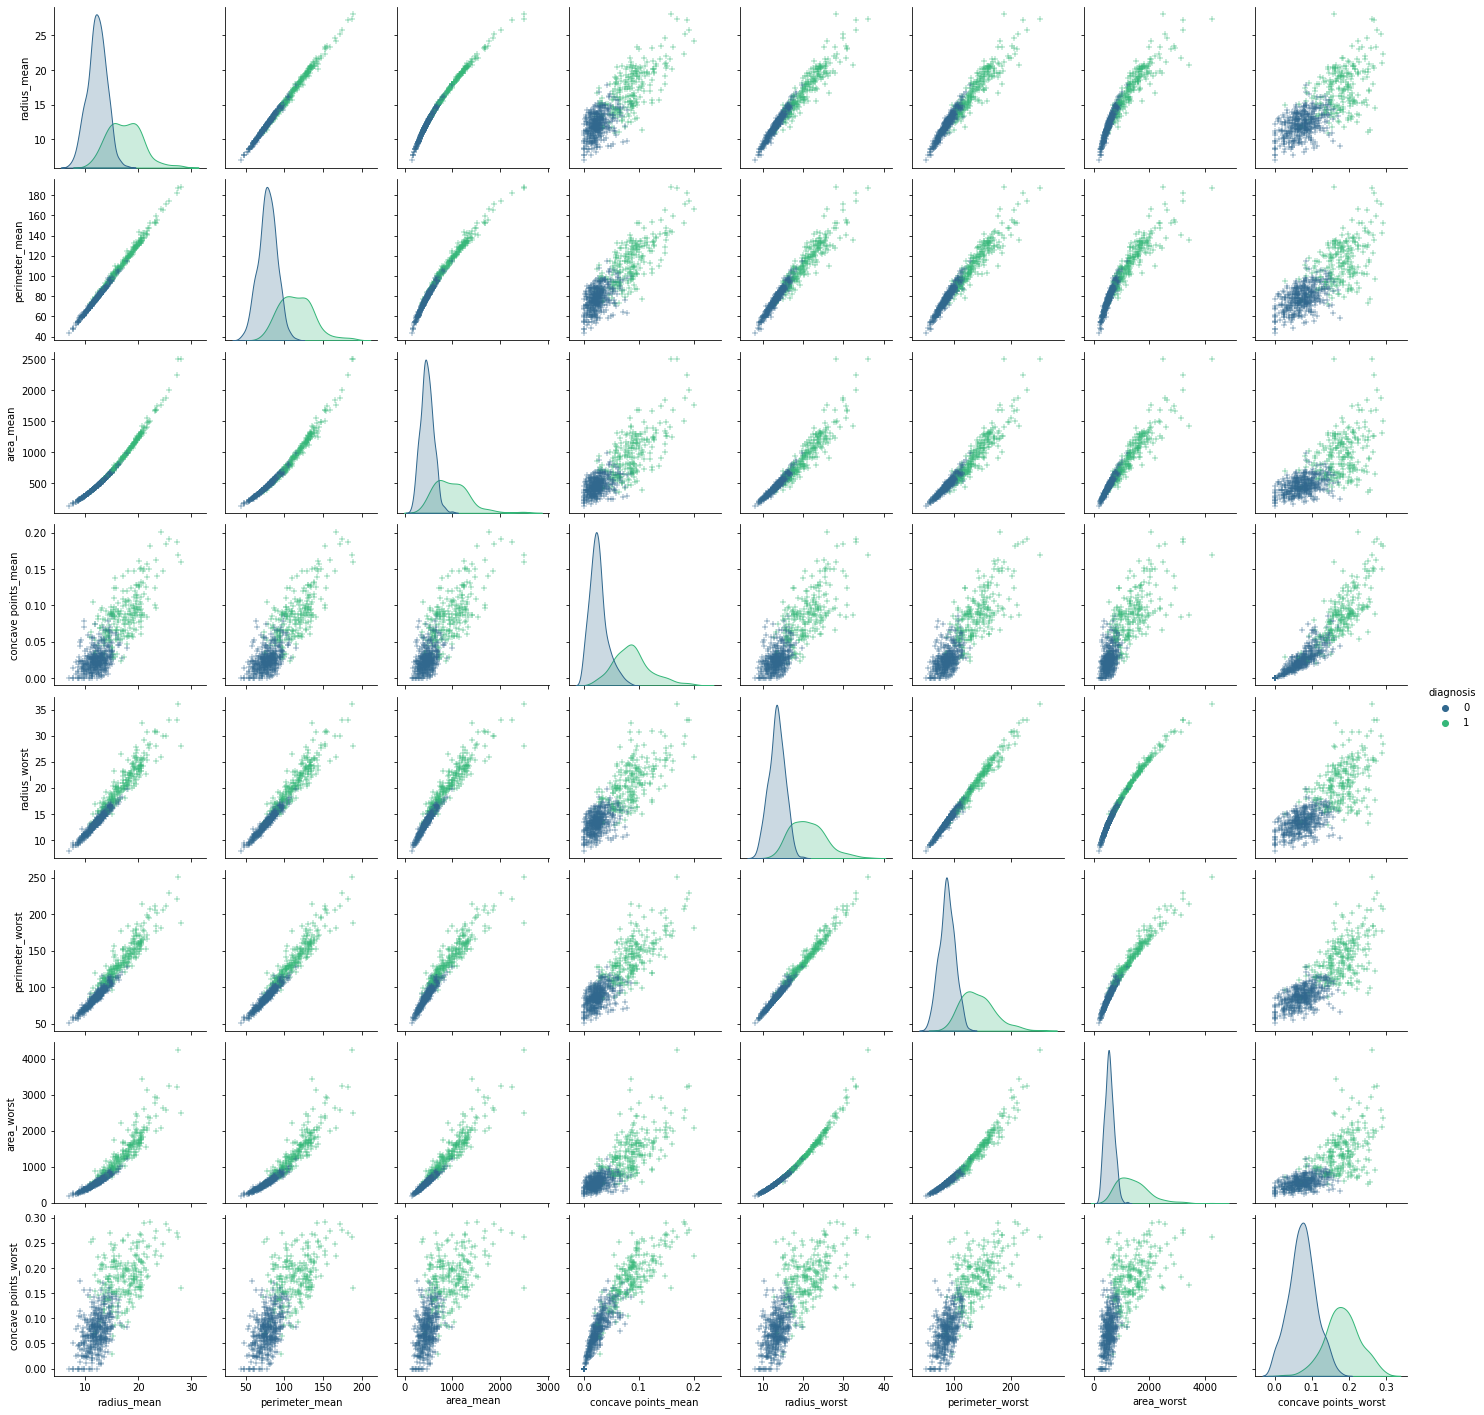

In [17]:
plt.figure(figsize=(20,14))
sns.pairplot(df,diag_kind = "kde", markers = "+", hue = "diagnosis", palette='viridis')
plt.show()

We clearly see that there are high indicators for malignant neoplasms and our classifier can determine benign and malignant neoplasms.

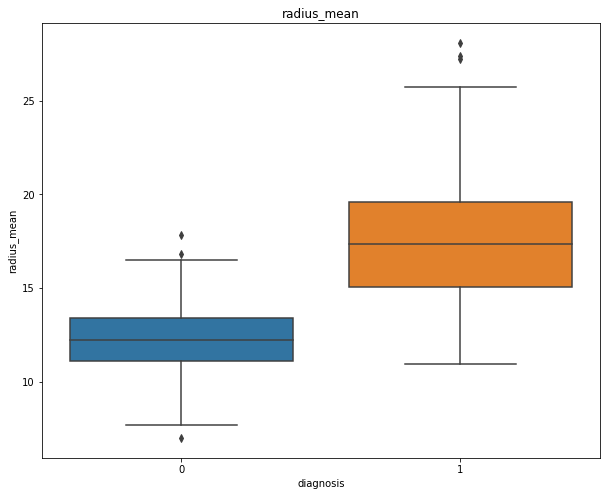

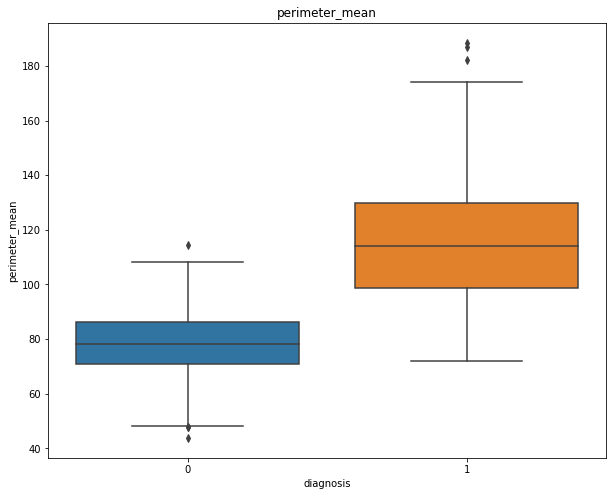

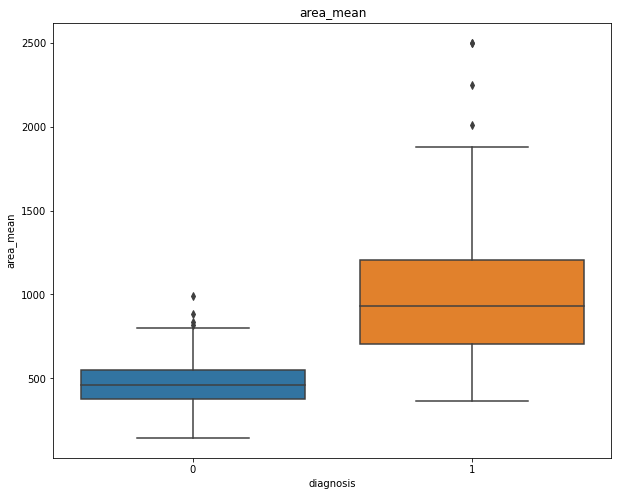

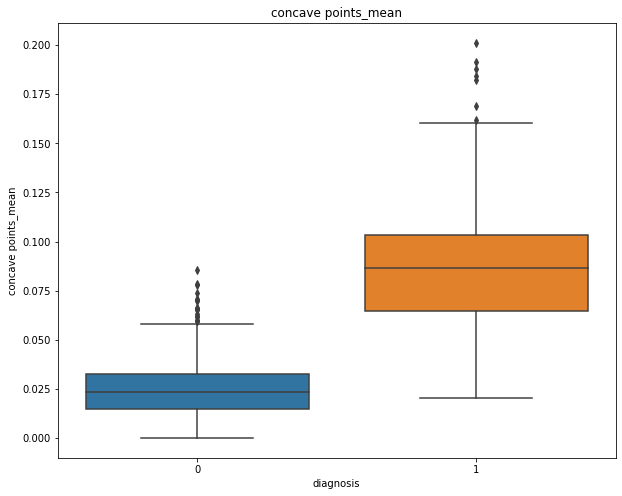

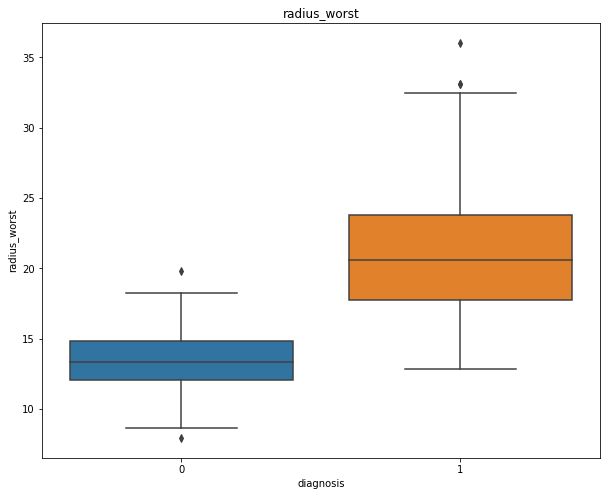

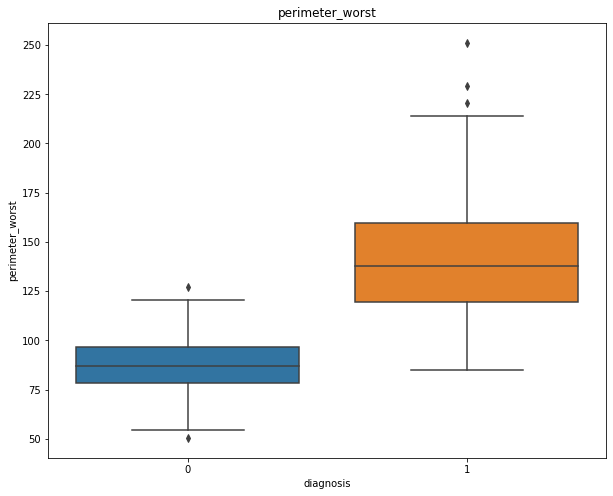

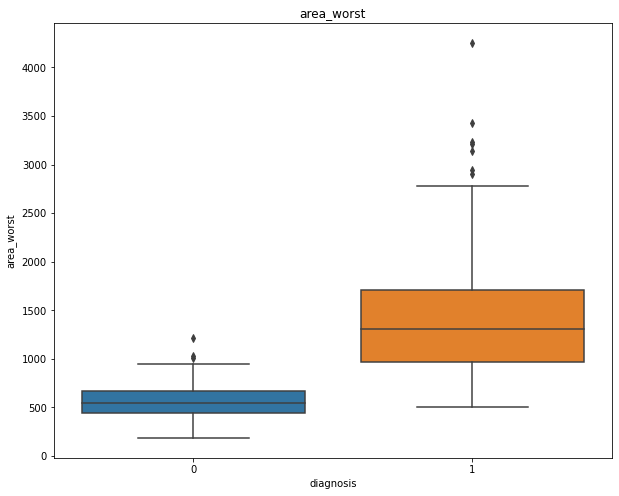

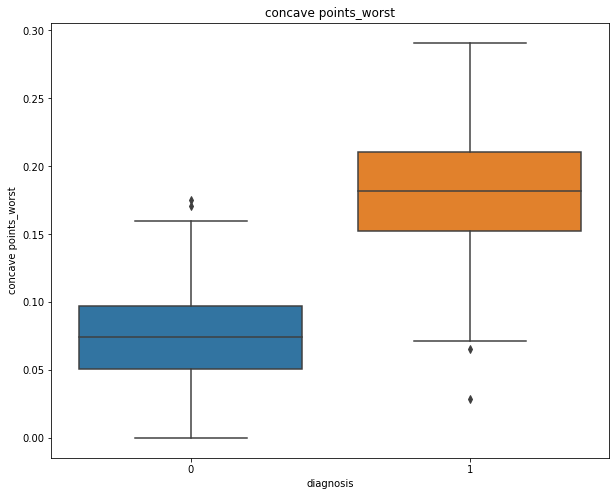

In [18]:
for col in df.columns:
    if col != 'diagnosis':
        plt.figure(figsize=(10,8))
        plt.title(col)
        sns.boxplot(x = 'diagnosis',y = col,data = df)
        plt.show()
    else: 
        pass

## Machine Learning Algorithms

For machine learning algorithms, we will use 3 classifiers. The settings will be by default. 

* random forest;
* logistic regression;
* gradient boosting.

In [19]:
clf_forest = RandomForestClassifier()
clf_log = LogisticRegression(solver = 'liblinear')
clf_xgb = XGBClassifier(objective ='binary:logistic')

clf = [clf_forest,clf_log,clf_xgb]

for i in clf:
    i.fit(X_train,y_train)


[09:21:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
y_forest = clf_forest.predict(X_test)
y_logreg = clf_log.predict(X_test)
y_xbg = clf_xgb.predict(X_test)

In [21]:
m = ['random forest','logistic regression','xgboost']
f_forest = f1_score(y_test,y_forest)
f_logreg = f1_score(y_test,y_logreg)
f_xgb = f1_score(y_test,y_xbg)
f_score = pd.DataFrame({'f1 score' :[f_forest,f_logreg,f_xgb],'model': m})


## Neural network

In [22]:
model = keras.Sequential([layers.BatchNormalization()
                          ,layers.Dense(20, activation = 'relu', input_shape = [8]),
                          layers.BatchNormalization(),
                          layers.Dense(20, activation = 'relu'),
                          layers.BatchNormalization(),
                          layers.Dense(1, activation = 'sigmoid')])
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['binary_accuracy'])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [23]:
history = model.fit(X_test,y_test,
                    epochs=30)

2022-03-02 09:21:57.429085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
6/6 [==============================] - 1s 3ms/step - loss: 0.4437 - binary_accuracy: 0.7766
Epoch 2/30
6/6 [==============================] - 0s 3ms/step - loss: 0.3309 - binary_accuracy: 0.8670
Epoch 3/30
6/6 [==============================] - 0s 3ms/step - loss: 0.2656 - binary_accuracy: 0.9149
Epoch 4/30
6/6 [==============================] - 0s 3ms/step - loss: 0.2350 - binary_accuracy: 0.9096
Epoch 5/30
6/6 [==============================] - 0s 2ms/step - loss: 0.1983 - binary_accuracy: 0.9468
Epoch 6/30
6/6 [==============================] - 0s 2ms/step - loss: 0.1969 - binary_accuracy: 0.9255
Epoch 7/30
6/6 [==============================] - 0s 2ms/step - loss: 0.1467 - binary_accuracy: 0.9840
Epoch 8/30
6/6 [==============================] - 0s 2ms/step - loss: 0.1417 - binary_accuracy: 0.9734
Epoch 9/30
6/6 [==============================] - 0s 3ms/step - loss: 0.1512 - binary_accuracy: 0.9521
Epoch 10/30
6/6 [==============================] - 0s 3ms/step - loss: 0.

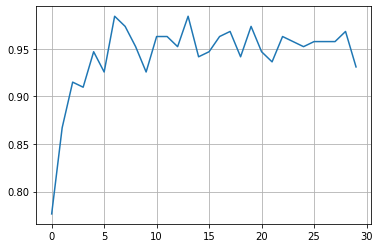

In [24]:
history_score = pd.DataFrame(history.history)
plt.plot(history_score[['binary_accuracy']])
plt.grid()
plt.show()

In [25]:
predict = model.predict(X_test)

##  Analysis of results 

In [26]:
f_score.loc[len(f_score)] = [f1_score(y_test,np.rint(predict)),'Neural network']

In [27]:
f_score

,f1 score,model
0,0.946565,random forest
1,0.955224,logistic regression
2,0.947368,xgboost
3,0.881579,Neural network


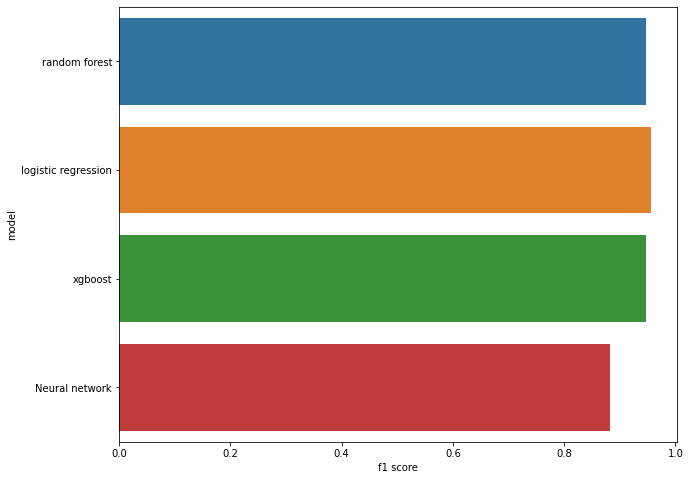

In [28]:
plt.figure(figsize=(10,8))
sns.barplot(y = 'model',x='f1 score',data = f_score)
plt.show()

In [29]:
cm_forest = confusion_matrix(y_test,y_forest,labels = clf_forest.classes_)
cm_logreg = confusion_matrix(y_test,y_logreg,labels = clf_log.classes_)
cm_xgb = confusion_matrix(y_test,y_xbg,labels = clf_xgb.classes_)

disp_forest = ConfusionMatrixDisplay(confusion_matrix=cm_forest,display_labels=clf_forest.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg,display_labels=clf_log.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,display_labels=clf_xgb.classes_)

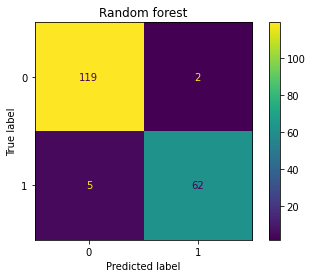

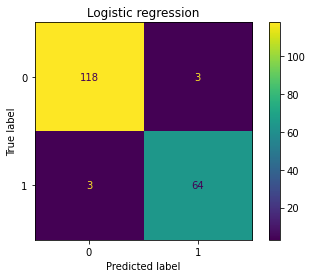

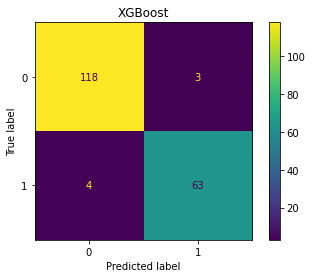

In [30]:
labels = ['Random forest','Logistic regression','XGBoost']
disp = [disp_forest,disp_logreg,disp_xgb]
for i,l in zip(disp,labels):
    i.plot()
    plt.title(l)
    plt.show()

In [31]:
cm_nn = confusion_matrix(y_test, np.rint(predict))

disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)

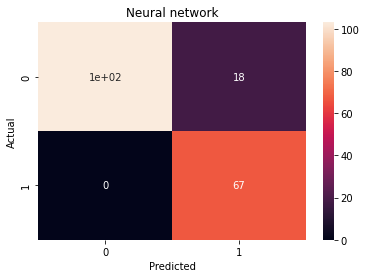

In [32]:
sns.heatmap(confusion_matrix(y_test.to_numpy(), np.rint(predict)),annot=True)
plt.title('Neural network')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
fpr_f,tpr_f, _ = roc_curve(y_test, y_forest)
fpr_l,tpr_l, _ = roc_curve(y_test, y_logreg)
fpr_x,tpr_x, _ = roc_curve(y_test, y_xbg)
auc_f = auc(fpr_f,tpr_f)
auc_l = auc(fpr_l,tpr_l)
auc_x = auc(fpr_x,tpr_x)

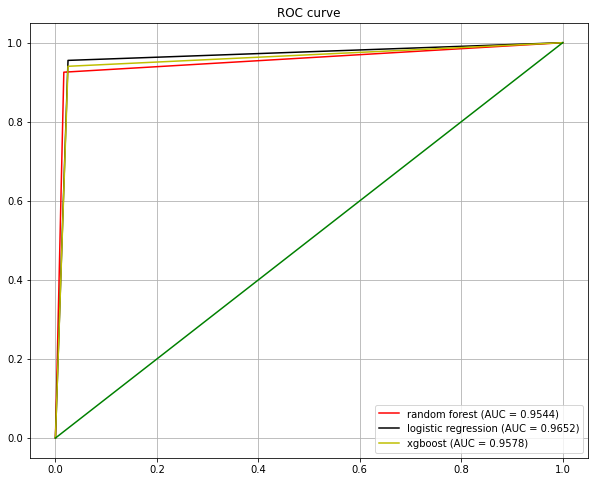

In [34]:
plt.figure(figsize=(10,8))
plt.title('ROC curve')
l1, = plt.plot(fpr_f,tpr_f,color = 'r',label='random forest (AUC = %0.4f)'%auc_f)
l2, = plt.plot(fpr_l,tpr_l,color = 'k',label='logistic regression (AUC = %0.4f)'%auc_l)
l3, = plt.plot(fpr_x,tpr_x,color = 'y',label='xgboost (AUC = %0.4f)'%auc_x)
plt.plot([0, 1], [0, 1],color = 'g')
plt.legend(handles = [l1,l2,l3])
plt.grid()
plt.show()

In [35]:
fpr_nn,tpr_nn, _ = roc_curve(y_test, predict)
auc_nn = auc(fpr_nn,tpr_nn)

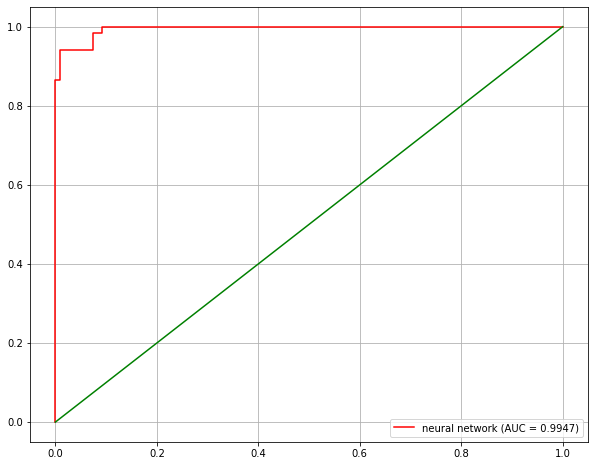

In [36]:
plt.figure(figsize=(10,8))
l4, = plt.plot(fpr_nn,tpr_nn,color = 'r',label = 'neural network (AUC = %0.4f)'%auc_nn)
plt.plot([0, 1], [0, 1],color = 'g')
plt.legend(handles = [l4])
plt.grid()
plt.show()

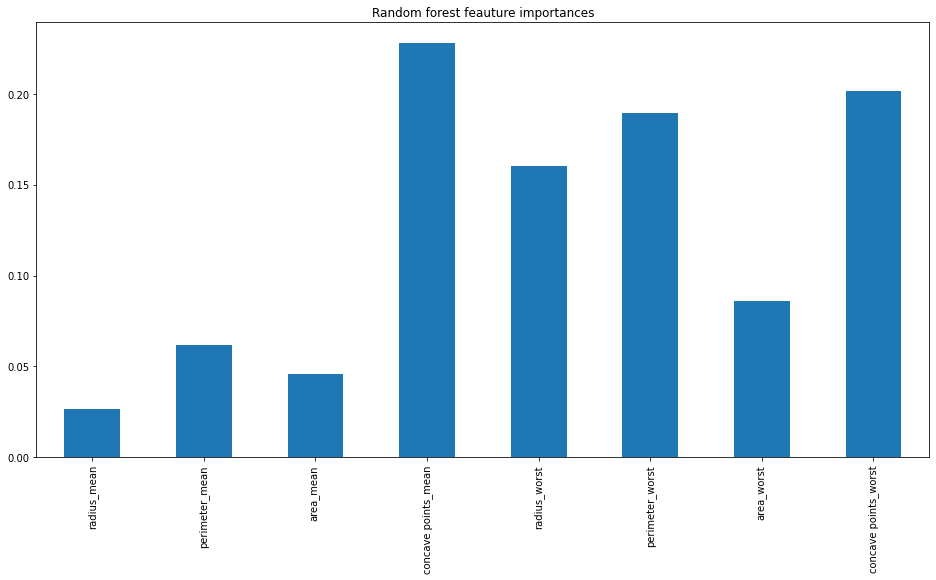

In [37]:
plt.figure(figsize=(16,8))
plt.title('Random forest feauture importances')
pd.Series(clf_forest.feature_importances_,index = X_test.columns).plot.bar()
plt.show()

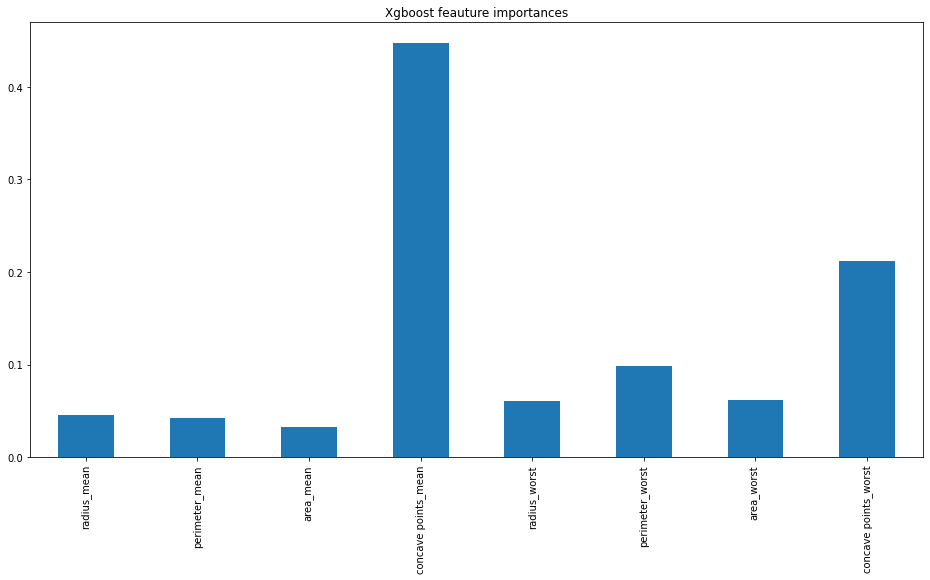

In [38]:
plt.figure(figsize=(16,8))
plt.title('Xgboost feauture importances')
pd.Series(clf_xgb.feature_importances_,index = X_test.columns).plot.bar()
plt.show()

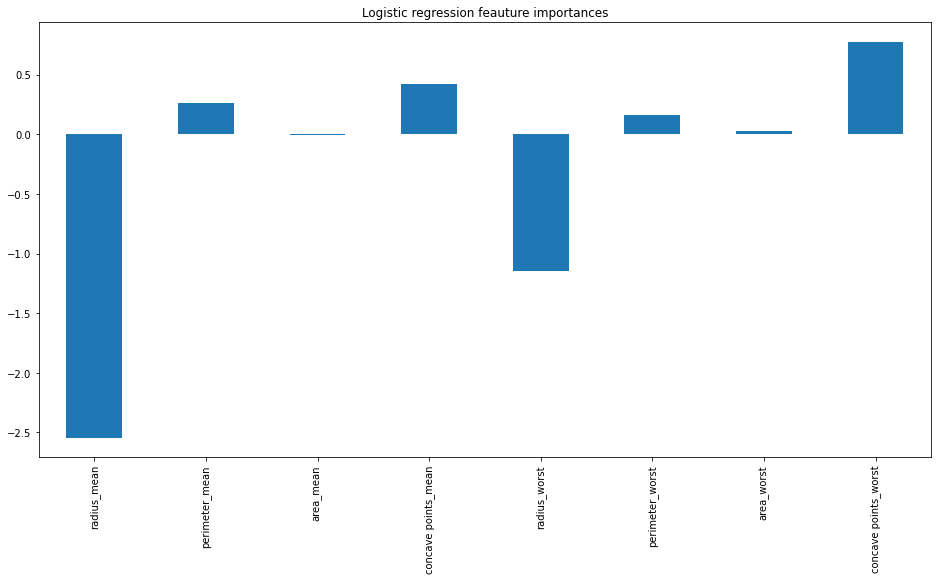

In [39]:
plt.figure(figsize=(16,8))
plt.title('Logistic regression feauture importances')
pd.Series(clf_log.coef_[0],index = X_test.columns).plot.bar()
plt.show()

## Conclusions

* F1-score is the highest for logistic regression. The neural network shows minimal results. It makes sense to evaluate these algorithms if you use machine learning algorithms without their default settings.
* The roc-auc metric shows high results in a neural network. for binary classification, this metric shows itself best because it displays the true and constant ability of the model to predict.
* Graphs of the importance of features are constructed and they have different weights for different models, this is due to the peculiarities of their mathematics. It can be seen that the graphs of the random forest and xgboost are similar, this is due to the fact that they are based on the construction of decision trees.